In [13]:
from importlib import reload
import evosim
reload(evosim); None

# Learning Goals: 
- learn some population genetics
- understand pop gen simulations
- understand interactions of the 4 forces:
    - selection vs. drift (Ns)
    - selection vs. length of environmental epoch (sT)
    - drift in finite and infinite populations
    - long-term ("indirect"?) selection on mutation rate!

pair up -> at least 1 person who knows Python per group

# Simulation setup

### Six possible genotypes

We will consider a fixed population size of N individual organisms, each of which has a certain genotype.

At the "major locus" (or "selected locus") there are two possible alleles : *A* and *B*.
The alleles *A* and *B* will have different fitnesses in two environments *A* and *B*.

There are three possible alleles at the "mutator locus": *M<sub>2</sub>*, *M<sub>3</sub>*, *M<sub>4</sub>*. There is no direct selection on the mutator locus; it just sets the rate of mutation from *A*->*B* or *B*->*A* in offspring.

This makes a total of 2 * 3 = 6 possible genotypes:

|                   | A                       | B |
| :--------------   | :------:                | :----:               |
| *M<sub>2</sub>*   |   (*M<sub>2</sub>*, A)  | (*M<sub>2</sub>*, B) |
| *M<sub>3</sub>*   |   (*M<sub>3</sub>*, A)  | (*M<sub>3</sub>*, B) |
| *M<sub>4</sub>*   |   (*M<sub>4</sub>*, A)  | (*M<sub>4</sub>*, B) |

The organisms in our model are asexual - there is no mating/recombination. Offspring have a single parent. 

### Each generation of evolution
At each generation, in a typical population genetics model (like this one), we will:

- start with a count of each genotype
- convert to non integer "frequencies" (proportions of each genotype out of N)
- apply selection (to the frequencies, yielding an expected frequency of each type after selection)
    - selection is an AVERAGE effect
- apply mutation (to the frequencies, yielding an expected frequency of each type after mutation)
    - mutation is an AVERAGE effect
- randomly SAMPLE back to integer counts of each genotype
    - This is where drift arises!
    - However: drift weakens as population size increases, to the limit of no drift in infinite populations.
    - So, in "the infinite population limit", we don't need to sample, we just track frequencies, not integer counts.

If there's no mutation, the offspring inherits the parent's value of A or B. If there is a mutation, the inherited allele switches *A->B* or *B->A* from the parent's value.

### Selection:
There will be two environments in our model. At any generation the current "environmental state” is either *A* or *B*. (This state can change over time.)

Environment *A* favors selected allele *A*, and environment *B* favors selected allele *B*.

Organisms holding the allele at the selected locus that matches the state of the environment will produce more offspring on average: they are more fit.

Specifically, given a “selection coefficient” *s*, the matching (fitter) organisms produce 1+*s* times as many offspring. This means that the fitter organisms will increase in relative number.


```python
def apply_selection(p, s): # p is an expected frequency (float)
    """
    Return expected fraction of A after selection.
    Assumes just 2 types: A and B.

    Args:
      p: current frequency of A (0 <= p <= 1)
      s: selection coefficient (so wA = 1 + s, wB = 1)

    Explanation of components:
      wA = 1 + s                 # fitness of A
      wB = 1                     # fitness of B
      numerator = wA * p         # A's contribution to the post-selection pool
      denominator = wA*p + wB*(1-p)  # total contribution from A and B
      result = numerator / denominator
    """

    wA = 1.0 + float(s)   # fitness of A
    wB = 1.0              # fitness of B

    numerator = wA * p # (unnormalized) "proportion" of A
    denominator = numerator + wB * (1.0 - p) # total (unnormalized) "proportions" of A + B

    return numerator / denominator # nomalized, expected frequency after selection (0 <= p <= 1)
```

### Mutation
The alleles M2, M3, M4 at the mutator locus produce mutation rates in the selected locus of 10-2, 10-3, 10-4, respectively. The rate is symmetric, A->B, or B->A.

For example, at each generation, an individual with genotype (A, M2) produces offspring that are 99% (A, M2), and 1% (B, M2); that is, the A mutates to B in 1 out of 102 offspring.

Similarly, an individual with genotype (A, M4) produces offspring that are 99.99% (A, M4), and 0.01% (B, M4);  that is, the A mutates to B in 1 out of 104 offspring.

It's symmetrical in the other direction from B->A.

The mutator locus itself never mutates. That means that all descendants of an individual possessing an M2 at the mutator locus will always possess an M2 (and likewise for M3, M4). This constraint in our particular experimental setup makes the mutator locus a convenient marker of clade identity. So, we can refer to the M2 clade as being founded by all the M2 individuals at generation 0, and all of its descendant members will always possess an M2 forever.

```python
def apply_mutation(p, mu): # p is an expected frequency (float)
    """
    Return expected fraction of A after symmetric mutation at rate `mu`.
    Assumes just 2 types: A and B.

    Args:
      p: current frequency of A (0 <= p <= 1)
      mu: per-generation mutation probability for A->B and B->A (0 <= mu <= 1)

    Explanation of components:
      p_remain = p * (1 - mu)      # fraction of current A that do NOT mutate
      p_from_B = (1 - p) * mu      # fraction of current B that mutate to A
      result = p_remain + p_from_B # total fraction of A after mutation
    """

    p_remain = p * (1.0 - mu)
    p_from_B = (1.0 - p) * mu

    return p_remain + p_from_B # expected frequency after mutation (0 <= p <= 1)
```

---
### Sampling from a binomial distribution – which produces drift

mean: 1.000		should be ~Np: 2.000
stddev/N: nan	should be ~sqrt(p(1-p)/N): 0.12649


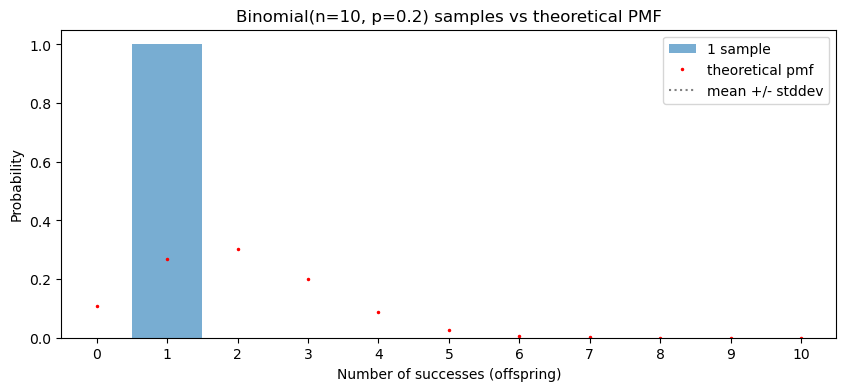

In [90]:
from helpers import plot_binomial_samples

# N - number of individuals in the population
# p - what fraction of the population will a given genotype make up, on average
#    p is determined by selection coefficient s, the mutation rate mu, and the previous proportions of genotypes.

# Then we draw a sample from a binomial distribution with parameters N and p
#    The mean of the binomial distribution is N*p - average number of individuals of that type
#    The min of the binomial is 0 - no individuals of that type
#    The max of the binomial is N - all individuals are of that type

# One sample is ONE draw of "how many individuals of type A do we get in the next generation?".

N = 10 # 100
p = 0.2 # 0.2
samples = 1
plot_binomial_samples(N, p, samples)

---
# Simulations

In [91]:
# Here are all the default arguments.
# Any arguments you add below will override these defaults.

display("default arguments:", evosim.default_args)

'default arguments:'

{'numPops': 1,
 'N': 100000.0,
 'minMu': 2,
 'numClades': 1,
 'aToB': 0.5,
 'T': 1000.0,
 'numEpochs': 1,
 's': 0.1,
 'includeMutation': True,
 'plotLog': False,
 'plotAB': True,
 'printStats': False,
 'stochasticEnv': False}

---
### Drift (no selection or mutation)

Drift is change in genotype frequencies due to stochasticity (e.g., in number of offspring produces

Drift is stronger with low N (population size).

- Change N between 1e2 and 1e9

Re-run (Cmd-return) multiple times with different parameters.

Ns:0.0 is low < 10.0 (selection is WEAK relative to drift)
sT:0.0 is low < 20.0 (fixation WON'T usually happen in one epoch)


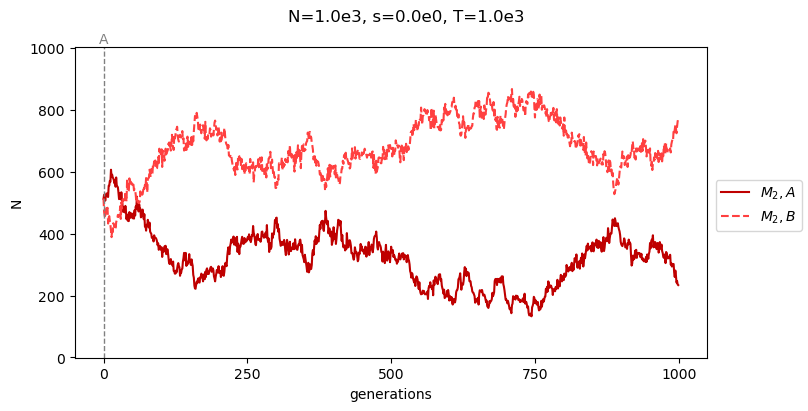

In [92]:
# Goal: to see effect of population size on drift, over time
args = evosim.default_args.copy()

args.s = 0.0 # NO SELECTION when s=0.0
args.includeMutation = False # False = NO MUTATION

args.N = 1e3 # 1e3
args.T = 1e3 # 1e3

# Re-run multiple times (Cmd-return) with different parameters.
# experiment 1: change N between 1e2 and 1e9, re-run multple times (Cmd-return) 
# experiment 2: compare large N to N=-1 (which means infinite population)

# Notice how often A or B "fixes" (reaches 100% frequency) in small vs large populations, and over time
# The opposite of "fix" is "go extinct" (reach 0% frequency)

# Now try varying T. With long T like 1e4, there is plenty of time for eventual fixation/extinction
# With T=1e2 we rarely get close to fixation/extinction (with drift only, no selection)

evosim.evosim(args)

---
### Selection (without mutation)

Change N to see differential effect of selection vs drift.

Change s to see effect of selection strength.

- if Ns is high >= 10.0 then selection will be STRONG relative to drift
- if sT is low < 20.0 then fixation won't usually happen in one epoch (T generations)
- Type *A* should fix if Ns > 1, and sT > 5


Re-run multiple times (Cmd-return) with different parameters.

Ns:10.0 is high >= 10.0 (selection is STRONG relative to drift)
sT:10.0 is low < 20.0 (fixation WON'T usually happen in one epoch)


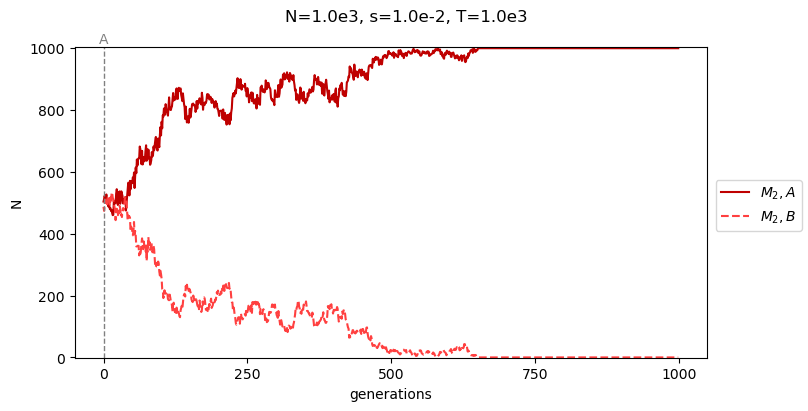

In [ ]:
# Goal: to see effect of selection vs. drift
args = evosim.default_args.copy()

args.s = 0.01 # s = 0.001
args.includeMutation = False # False = no mutation

args.N = 1e3
args.T = 1e3

# Compared to the last experiment, we have added SELECTION (s > 0)
# Note that, now, A fixes more often than B

# Notice the first 2 lines of text below about Ns and sT
# Ns < ~10 means that selection is WEAK relative to drift
# sT < ~20 mean that fixation WON'T usually happen in one epoch
#    that is, selection is generally too weak to "fix" a genotype within T generations
 
# Re-run multiple times (Cmd-return) with different parameters.
# experiment 1: change s between 0.001, 0.001, 0.1, re-run multple times (Cmd-return)
# experiment 2: compare various N: 1e2... 1e9, -1 (which means infinite population)
# experiment 3: compare various T: 1e3... 1e6, -1 (which means infinite population)

evosim.evosim(args)

---
### Selection vs mutation, and mutation-selection balance

Ns:1000.0 is high >= 10.0 (selection is STRONG relative to drift)
sT:100.0 is high >= 20.0 (fixation CAN happen in one epoch (ignoring mutation))


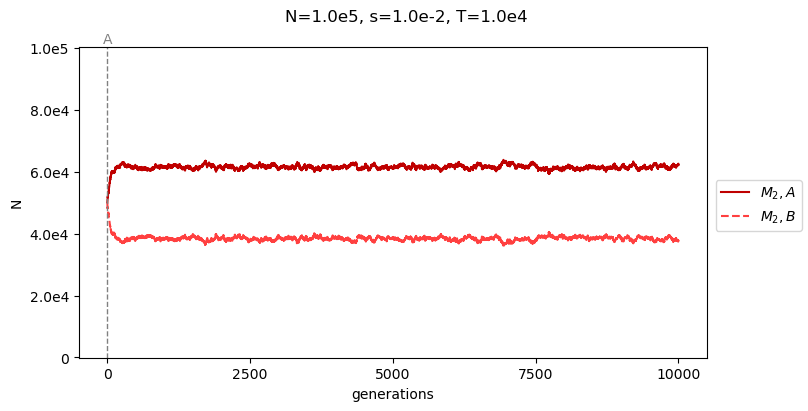

In [134]:
# Goal: to see effect of selection vs mutation, and mutation-selection balance
args = evosim.default_args.copy()

args.s = 0.01 # 0.01
args.includeMutation = True # True

args.N = 1e5
args.T = 1e4

args.minMu = 2 # 2

# Re-run multiple times (Cmd-return) with different parameters.
# experiment 1: change minMu between 2 and 5, re-run multple times (Cmd-return)
# "mutation selection balance" means that selection pushing A up is balanced by mutation pushing A down

# experiment 2: compare large N to N=-1 (which means infinite population)

evosim.evosim(args)

---
### Selection in alternating environments

Infinite population size N (there is no drift)
sT:10.0 is low < 20.0 (fixation WON'T usually happen in one epoch)


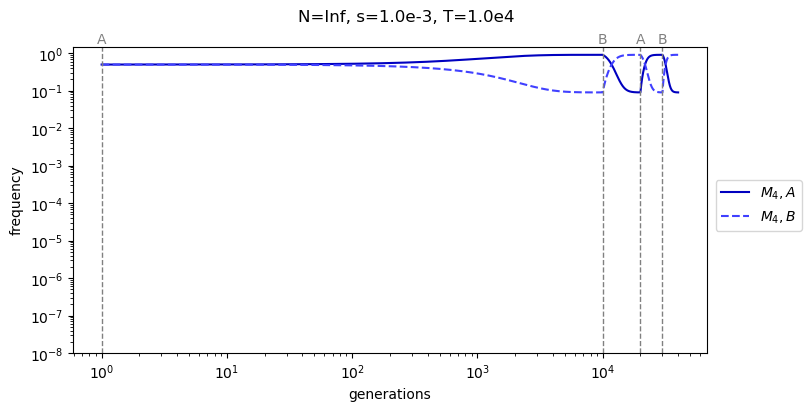

In [ ]:
args = evosim.default_args.copy()

args.minMu = 4

args.s = 0.001 # change this to see effect of selection strength
args.includeMutation = True

args.T = 1e4
args.numEpochs = 4
# BTW runtime is linear in T * numEpochs

args.N = -1 # change this and re-run to see differential effect of selection vs drift

# try args.plotLog = True
# args.plotLog = True

evosim.evosim(args)

---
### Selection on different mutators (!!) in alternating environments

The mutation rate possessed by an organism does not affect its fitness.

That is,
- there is selection *on the organism's external phenotype*
- but because mutation rate *only affects the offspring*, is not "visible" to single-generation selection.

Nonetheless, we can show that there is “long-term selection” on mutation rate

Infinite population size N (there is no drift)
sT:100.0 is high >= 20.0 (fixation CAN happen in one epoch (ignoring mutation))


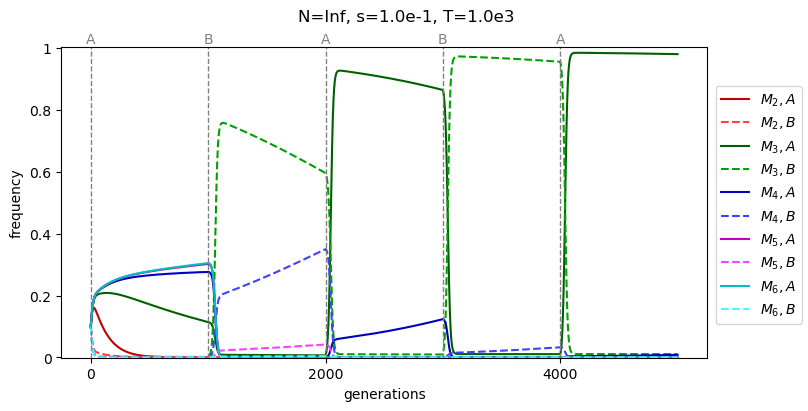

In [203]:
args = evosim.default_args.copy()

args.minMu = 2
args.numClades = 5

args.s = 0.1 # s has to be kept high relative to T, so that sT is not too small
args.includeMutation = True

args.T = 1e3 # try 1e2, 1e3, 1e4, 1e5 - notice that M2, M3, M4, M5 win!
args.numEpochs = 5 # 5

args.N = -1 # change this to finite to see differential effect of selection vs drift

# try: args.plotAB = False to just see individual clades of mutators
# args.plotAB = False

# try args.plotLog = True to see longer term dynamics
# You can also increase args.numEpochs to 10, 20
# args.plotLog = True

evosim.evosim(args)

### Stochastic environments

Infinite population size N (there is no drift)
sT:10.0 is low < 20.0 (fixation WON'T usually happen in one epoch)


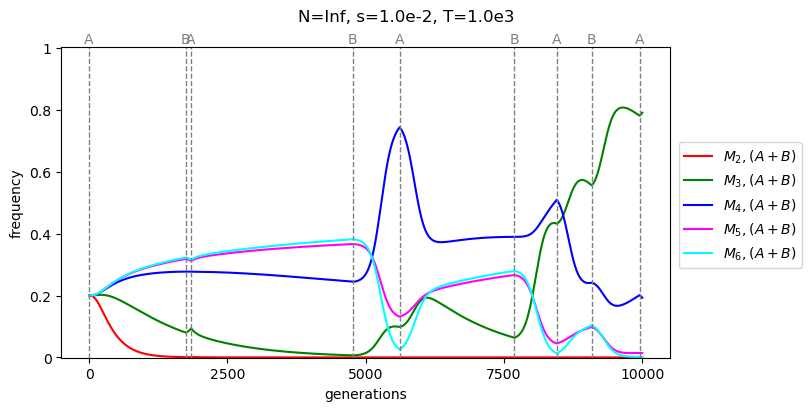

In [204]:
args = evosim.default_args.copy()

args.minMu = 2
args.numClades = 5

args.s = 0.01 # change this to see effect of selection strength
args.includeMutation = True
args.T = 1e3
args.numEpochs = 10
args.stochasticEnv = True

args.N = -1 # change this and re-run to see differential effect of selection vs drift
args.plotAB = False
#args.plotLog = True

evosim.evosim(args)

Infinite population size N (there is no drift)
sT:100000.0 is high >= 20.0 (fixation CAN happen in one epoch (ignoring mutation))


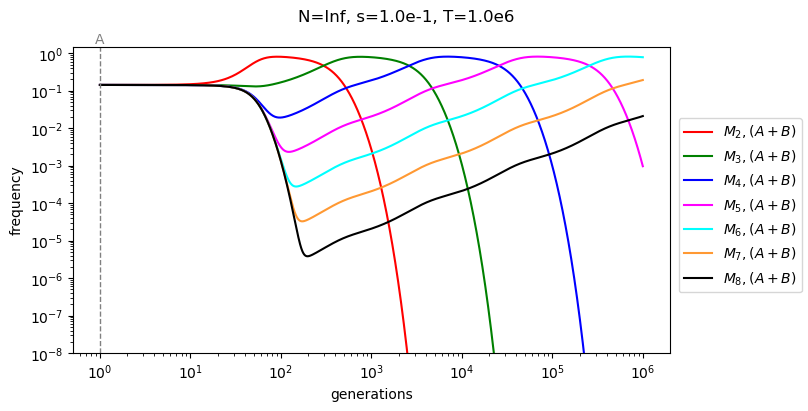

In [23]:
args = evosim.default_args.copy()

args.minMu = 2
args.numClades = 7

args.s = 0.1 # change this to see effect of selection strength
args.includeMutation = True
args.T = 1e6
args.numEpochs = 1
args.stochasticEnv = False
args.aToB = 0.0

args.N = -1 # change this and re-run to see differential effect of selection vs drift
args.plotAB = False
args.plotLog = True

evosim.evosim(args)

Ns:10000.0 is high >= 10.0 (selection is STRONG relative to drift)
sT:100000.0 is high >= 20.0 (fixation CAN happen in one epoch (ignoring mutation))


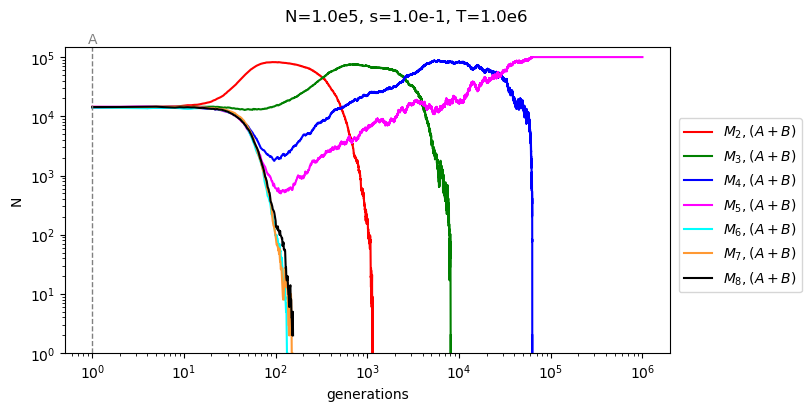

In [24]:
args = evosim.default_args.copy()

args.minMu = 2
args.numClades = 7

args.s = 0.1 # change this to see effect of selection strength
args.includeMutation = True
args.T = 1e6
args.numEpochs = 1
args.stochasticEnv = False
args.aToB = 0.0

args.N = 1e5 # change this and re-run to see differential effect of selection vs drift
args.plotAB = False
args.plotLog = True

evosim.evosim(args)